# Building and Training a Simple RNN Model using PyTorch for Predicting Sine Wave Patterns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Generate data

Let's create a simple dataset to train our network on. We'll use a sine wave as the input sequence and try to predict the next value in the sequence. We'll create a dataset of 1000 sequences with 10 time steps each.

In [5]:
def generate_sine_wave_sequences(timesteps: int, data_size: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic sine wave sequences for time series forecasting model training and testing.
    
    Creates artificial time series data by sampling segments from sine waves with random phase shifts.
    This synthetic data generation approach is commonly used for:
    - Testing time series forecasting algorithms on known patterns
    - Debugging neural network architectures before applying to real data
    - Educational demonstrations of sequence prediction concepts
    - Benchmarking model performance on predictable periodic signals
    
    Each generated sequence represents a continuous segment of a sine wave, with the prediction
    target being the natural continuation of that wave. The random phase shifts ensure model
    generalization across different starting points in the periodic cycle.
    
    Args:
        timesteps (int): Length of each input sequence (lookback window).
            Determines how many previous sine wave points the model observes
            to predict the next value. Typical values: 5-50 depending on
            the periodicity and complexity of patterns to be learned.
        data_size (int): Total number of training sequences to generate.
            Larger datasets improve model training but increase computation time.
            Typical values: 1000-10000 for experimentation, more for production.
            
    Returns:
        tuple: Two numpy arrays for supervised learning:
            - input_data (np.ndarray): Input sequences with shape (data_size, timesteps, 1).
              Each sequence contains timesteps consecutive sine wave values.
              The third dimension (1) represents single feature per timestep.
            - output_data (np.ndarray): Target values with shape (data_size, 1).
              Each target is the sine wave value immediately following its
              corresponding input sequence.
              
    Mathematical Details:
        - Input sequences span [0 + offset, 3π + offset] for each random offset
        - Output values are computed at 3π + offset
        - Random offsets are uniformly distributed in [0, 2π]
        - This ensures diverse starting phases while maintaining periodicity
        
    Example:
        >>> # Generate 1000 sequences of length 10
        >>> X, y = generate_sine_wave_sequences(timesteps=10, data_size=1000)
        >>> print(f"Input shape: {X.shape}")   # (1000, 10, 1)
        >>> print(f"Output shape: {y.shape}")  # (1000, 1)
        >>> 
        >>> # Verify continuity: last input should approximately equal first prediction
        >>> sample_idx = 0
        >>> last_input = X[sample_idx, -1, 0]
        >>> prediction_target = y[sample_idx, 0]
        >>> print(f"Continuity check: {np.isclose(last_input, prediction_target)}")
        
    Note:
        The function uses a 3π range (1.5 periods) to provide sufficient context
        for learning periodic patterns while ensuring the prediction target represents
        a natural continuation of the input sequence.
    """
    """
    Initialize arrays to store generated sequences and targets.
    Pre-allocation improves memory efficiency compared to dynamic list appending.
    """
    input_data = np.zeros((data_size, timesteps, 1))
    output_data = np.zeros((data_size, 1))

    """
    Generate sequences with random phase offsets for diversity.
    Each iteration creates one training example with a unique starting phase.
    """
    for i in range(data_size):
        """
        Generate random phase offset to create diverse starting points.
        Uniform distribution over [0, 2π] ensures all possible sine wave phases
        are represented in the training data, improving model generalization.
        """
        rand_offset = np.random.random() * 2 * np.pi
        
        """
        Create input sequence from sine wave over [0+offset, 3π+offset] range.
        The 3π span (1.5 periods) provides sufficient periodic context for
        pattern recognition while maintaining computational efficiency.
        """
        input_data[i, :, 0] = np.sin(np.linspace(0.0 + rand_offset, 3 * np.pi + rand_offset, num=timesteps))
        
        """
        Set prediction target as the next sine wave value after input sequence.
        This creates a natural continuation forecasting task where the model
        must predict the next point in the periodic sequence.
        """
        output_data[i, 0] = np.sin(3 * np.pi + rand_offset)

    return input_data, output_data


"""
Execute sine wave sequence generation with specified parameters.
Creates dataset suitable for training recurrent neural networks on periodic prediction tasks.
"""
timesteps = 10
data_size = 1000

input_data, output_data = generate_sine_wave_sequences(timesteps, data_size)

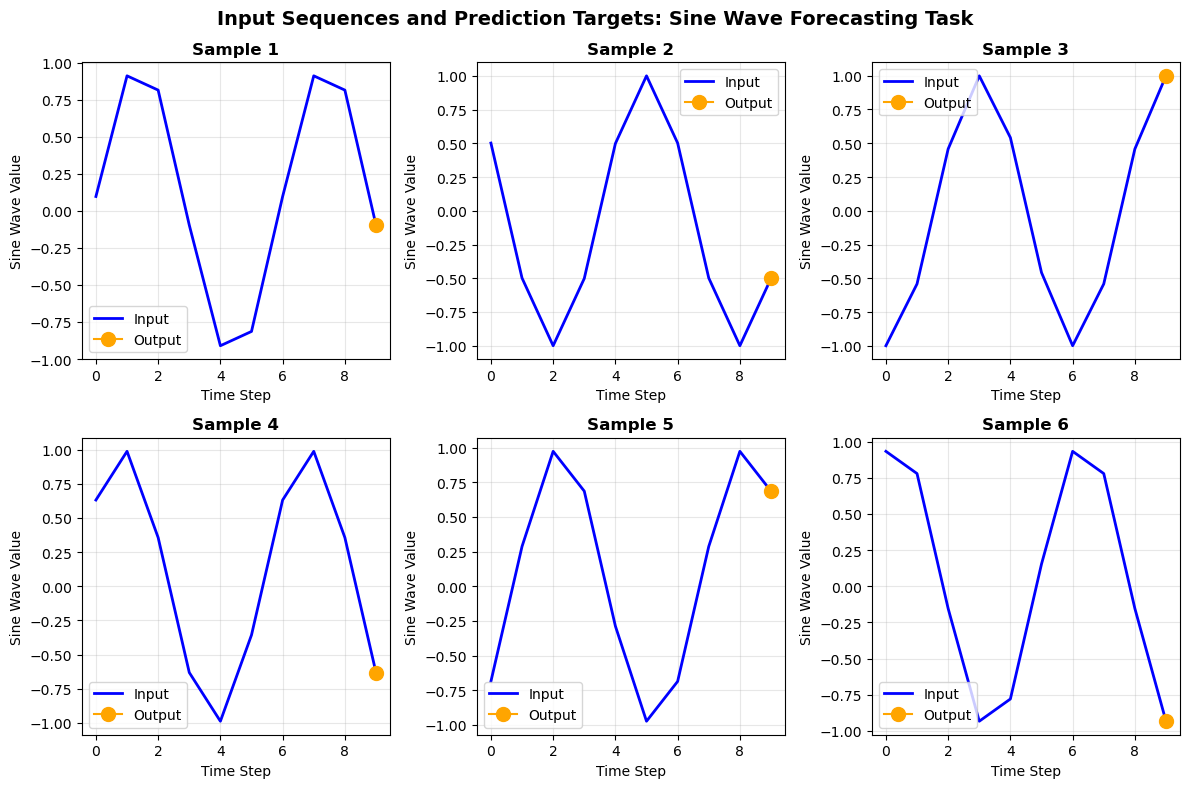

In [6]:
def visualize_sequence_samples(input_data: np.ndarray, output_data: np.ndarray, timesteps: int, n_samples: int = 6) -> None:
    """
    Create comprehensive visualization of input-output sequence pairs for data validation.
    
    Generates a multi-panel plot displaying sample sequences from the dataset to verify:
    - Input sequence patterns and continuity
    - Relationship between input sequences and prediction targets
    - Data quality and expected periodic behavior
    - Visual confirmation that outputs logically follow inputs
    
    This visualization is essential for debugging sequence generation and understanding
    the forecasting task before training neural networks. It helps identify potential
    issues like discontinuities, incorrect scaling, or unexpected patterns.
    
    Args:
        input_data (np.ndarray): Input sequences with shape (n_total_samples, timesteps, 1).
            Contains the sequential observations used as model inputs.
        output_data (np.ndarray): Target values with shape (n_total_samples, 1).
            Contains the prediction targets corresponding to input sequences.
        timesteps (int): Length of input sequences, used for proper axis positioning
            of output markers relative to input sequences.
        n_samples (int, optional): Number of sample sequences to display. Defaults to 6.
            Must be ≤ 6 due to fixed 2×3 subplot layout.
            
    Returns:
        None: Displays matplotlib figure with sequence visualizations.
        
    Raises:
        ValueError: If n_samples > 6 (exceeds subplot grid capacity).
        IndexError: If input arrays have fewer samples than requested.
        
    Example:
        >>> # Visualize first 6 sequences from generated data
        >>> visualize_sequence_samples(input_data, output_data, timesteps=10)
        >>> 
        >>> # Display only first 4 sequences
        >>> visualize_sequence_samples(input_data, output_data, timesteps=10, n_samples=4)
        
    Plot Details:
        - Blue lines: Input sequences showing temporal evolution
        - Orange circles: Prediction targets with enhanced visibility
        - Individual titles: Sample identification for reference
        - Consistent axes: Facilitate comparison across samples
        - Legends: Clear distinction between inputs and outputs
    """
    """
    Create 2×3 subplot grid for displaying up to 6 sequence samples.
    Figure size optimized for readability while fitting multiple panels.
    """
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    """
    Iterate through subplot grid positions to display sample sequences.
    Each subplot shows one complete input-output pair for pattern verification.
    """
    for i in range(2):
        for j in range(3):
            sample_idx = i * 3 + j  # Convert 2D grid position to linear index
            
            """
            Plot input sequence as continuous line to show temporal evolution.
            Blue color provides clear visual distinction from prediction target.
            """
            axs[i,j].plot(input_data[sample_idx, :, 0], label='Input', color='blue', linewidth=2)

            """
            Plot prediction target as prominent marker at continuation point.
            Positioned at timesteps-1 to show natural sequence continuation.
            Large marker size ensures visibility and emphasizes importance.
            """
            axs[i,j].plot(timesteps-1, output_data[sample_idx, 0], 
                         marker='o', markersize=10, label='Output', color='orange')

            """
            Configure subplot appearance for clarity and consistency.
            Titles enable sample identification, labels clarify axes meaning.
            """
            axs[i,j].set_title(f'Sample {sample_idx + 1}', fontweight='bold')
            axs[i,j].set_xlabel('Time Step')
            axs[i,j].set_ylabel('Sine Wave Value')
            axs[i,j].legend()
            axs[i,j].grid(True, alpha=0.3)  # Subtle grid for easier value reading

    """
    Configure overall figure appearance and layout optimization.
    Super title provides context, tight layout prevents overlap.
    """
    plt.suptitle('Input Sequences and Prediction Targets: Sine Wave Forecasting Task', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


"""
Visualize sample sequences to verify data generation quality and patterns.
Essential step before model training to ensure synthetic data meets expectations.
"""
visualize_sequence_samples(input_data, output_data, timesteps)

Now, let's split the dataset into training and testing sets:

In [7]:
train_size = int(data_size * 0.8)

X_train = input_data[:train_size, :, :]
y_train = output_data[:train_size, :]

X_test = input_data[train_size:, :, :]
y_test = output_data[train_size:, :]

### Define the RNN model

We'll use a simple RNN with a single hidden layer:

In [8]:
class RnnNet(nn.Module):
    """
    A simple RNN-based neural network for time series prediction.

    Architecture:
        - RNN layer with 32 hidden units
        - Fully connected output layer
        - Processes sequences to single-step predictions

    Parameters in __init__:
        rnn (nn.RNN): 
            - input_size=1 (single feature)
            - hidden_size=32 (hidden units) 
            - num_layers=1 (single RNN layer)
            - batch_first=True (input shape: [batch, seq, feature])
        fc (nn.Linear):
            - in_features=32 (matches RNN hidden size)
            - out_features=1 (single output prediction)

    Forward Process:
        1. Input shape: [batch_size, sequence_length, 1]
        2. RNN processes full sequence
        3. Only last RNN output used (shape: [batch_size, 32])
        4. Linear layer produces final prediction (shape: [batch_size, 1])

    Example:
        >>> model = RnnNet()
        >>> x = torch.randn(64, 10, 1)  # batch of 64 sequences
        >>> output = model(x)
        >>> output.shape
        torch.Size([64, 1])
    """
    def __init__(self):
        super(RnnNet, self).__init__()

        # Create a new RNN layer with 1 input feature, 32 hidden units, and 1 layer
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

        # Create a new fully connected layer with 32 input features and 1 output feature
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        """
        Passes the input tensor through the RNN and the fully connected layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        # Pass the input tensor through the RNN layer, which returns a new tensor with
        # shape (batch_size, sequence_length, hidden_size)
        rnn_out, _ = self.rnn(x)

        # Pass the last output from the RNN layer through the fully connected layer,
        # which returns a new tensor with shape (batch_size, 1)
        fc_out = self.fc(rnn_out[:, -1, :])

        # Return the output tensor
        return fc_out

net = RnnNet()

We'll use mean squared error loss and the Adam optimizer:

In [9]:
"""
The MSE loss function is a commonly used loss function for regression problems. It measures the average of the squared 
differences between the predicted output and the true output. In our case, we want our RNN to predict the sine wave value 
at the last time step given the input sequence, which is a regression problem. Therefore, using the MSE loss function is 
appropriate.

The Adam optimizer is a popular stochastic gradient descent optimizer that is known for its efficiency and robustness. 
It adapts the learning rate for each parameter based on the first and second moments of the gradients. In other words, 
it adjusts the learning rate for each weight in the network based on how much and how quickly the weight is changing. 
This helps the optimizer converge faster and more reliably than other stochastic gradient descent optimizers. Therefore, 
using the Adam optimizer is a good choice for training our RNN.

In summary, we used the MSE loss function because we have a regression problem, and we used the Adam optimizer because 
it is efficient and robust.
"""

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

Now, we'll define our training loop. We'll train the network for 70 epochs and calculate the training and validation loss after each epoch:

In [12]:
"""
Executes the training loop for an RNN model with validation tracking.

Parameters:
    net (nn.Module): The RNN model to train
    X_train (np.ndarray): Training input sequences
    y_train (np.ndarray): Training target values
    X_test (np.ndarray): Validation input sequences
    y_test (np.ndarray): Validation target values
    criterion (nn.Module): Loss function (typically MSELoss)
    optimizer (torch.optim): Optimization algorithm (typically Adam)

Process Flow:
    1. Initializes empty lists for loss tracking
    2. For each epoch:
        a. Sets model to train mode
        b. Performs forward pass on training data
        c. Calculates and backpropagates loss
        d. Updates model parameters
        e. Evaluates model on validation set
        f. Records and prints both losses

Outputs:
    train_losses (list): Training loss per epoch
    val_losses (list): Validation loss per epoch

Example:
    >>> train_losses, val_losses = train_rnn(net, X_train, y_train, 
    ...                                     X_test, y_test, criterion, optimizer)
    >>> len(train_losses)
    70
"""
train_losses = []
val_losses = []

epoch_steps=70

for epoch in range(epoch_steps):
    net.train()
    optimizer.zero_grad()

    outputs = net(torch.Tensor(X_train))
    loss = criterion(outputs, torch.Tensor(y_train))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    net.eval()
    with torch.no_grad():
        outputs = net(torch.Tensor(X_test))
        val_loss = criterion(outputs, torch.Tensor(y_test))
        val_losses.append(val_loss.item())

    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, 70, loss.item(), val_loss.item()))

Epoch [1/70], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [2/70], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [3/70], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [4/70], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/70], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [6/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/70], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [10/70], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [11/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [12/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [15/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [18/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [19/70], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [20/70], Train 

Finally, let's plot the training and validation loss over epochs:

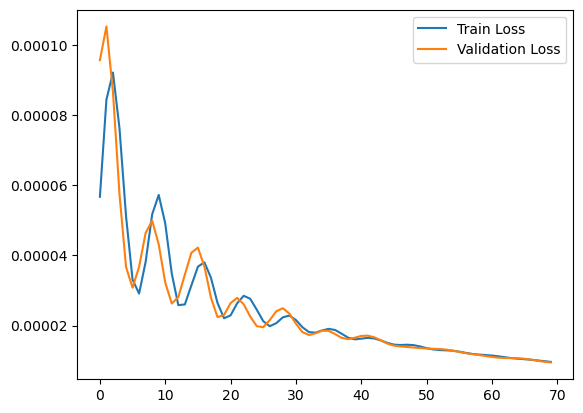

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()

And that's it! We've successfully trained a simple RNN to predict the next value in a sine wave sequence.